# Order-to-Insight – Visual Validation and Business Impact

This notebook validates the modeled data in DuckDB.

The goal is to:

- confirm that key metrics are calculated correctly  
- measure event completeness  
- show how missing events affect revenue and interpretation  

All queries use modeled tables. Raw CSV files are not used.

---

## 0. Setup

Connect to the local DuckDB warehouse and prepare figure output.

In [6]:
from pathlib import Path

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


BASE_DIR = Path.cwd().resolve().parents[0]  # notebook /analysis/ kansiossa
WAREHOUSE_DB = BASE_DIR / "data" / "processed" / "warehouse.duckdb"

FIG_DIR = BASE_DIR / "analysis" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)


def get_connection() -> duckdb.DuckDBPyConnection:
    if not WAREHOUSE_DB.exists():
        raise FileNotFoundError("warehouse.duckdb not found. Run the pipeline first.")
    return duckdb.connect(str(WAREHOUSE_DB))


def run_df(sql: str) -> pd.DataFrame:
    con = get_connection()
    try:
        return con.execute(sql).fetchdf()
    finally:
        con.close()


def save_fig(name: str) -> None:
    path = FIG_DIR / name
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print(f"Saved figure: {path}")


plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.axisbelow"] = True

print("Warehouse path:", WAREHOUSE_DB)
print("Figures directory:", FIG_DIR)
print("Setup completed.")



Warehouse path: C:\Users\honar\projektit\Order-to-Insight\data\processed\warehouse.duckdb
Figures directory: C:\Users\honar\projektit\Order-to-Insight\analysis\figures
Setup completed.


# Part I – Technical Validation

This section checks that the modeled data behaves as expected.
We validate time-based aggregation and event completeness.


### 1. Daily completed revenue

This chart shows completed revenue per day.
It helps check that aggregation over time is correct.

**Goal**

- Validate that daily aggregation from order-level data is correct  
- Detect missing days or unexpected discontinuities  
- Check boundary effects at the start and end of the dataset  


Saved figure: C:\Users\honar\projektit\Order-to-Insight\analysis\figures\01_daily_completed_revenue.png


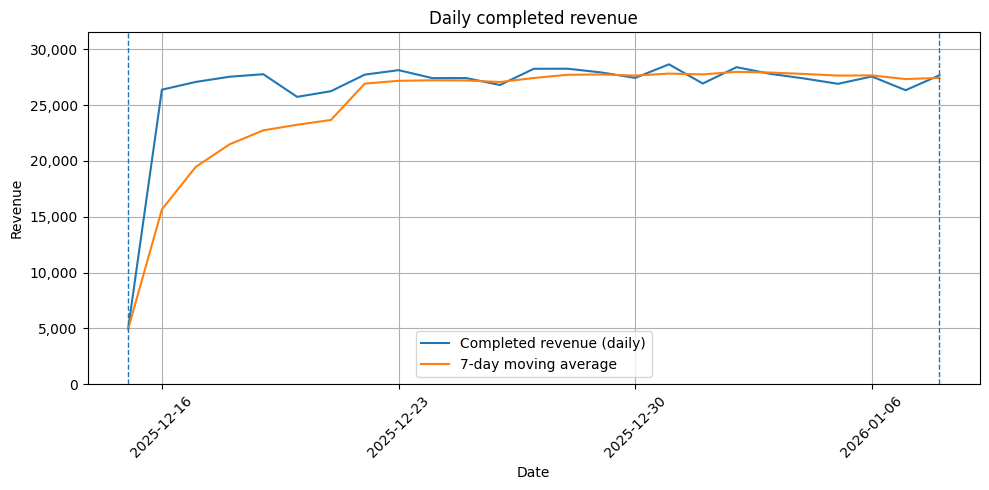

In [ ]:
# 1) Daily completed revenue (with 7-day moving average)
# Tarkoitus varmistaa, että päivittäinen aggregointi näyttää järkevältä ja ettei aikajanassa ole outoja katkoja.

import numpy as np
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

sql_daily = """
SELECT
  order_date,
  revenue_completed,
  orders_total,
  orders_completed
FROM fct_daily_revenue
ORDER BY order_date;
"""

df_daily = run_df(sql_daily)
df_daily["order_date"] = pd.to_datetime(df_daily["order_date"])
df_daily = df_daily.sort_values("order_date")

df_daily["revenue_ma7"] = (
    df_daily["revenue_completed"]
    .rolling(window=7, min_periods=1)
    .mean()
)

plt.figure()

plt.plot(
    df_daily["order_date"],
    df_daily["revenue_completed"],
    label="Completed revenue (daily)",
)

plt.plot(
    df_daily["order_date"],
    df_daily["revenue_ma7"],
    label="7-day moving average",
)

# Reunapäivien korostus synteettisessä datassa alku/loppu voi olla osittainen jakso
start_date = df_daily["order_date"].min()
end_date = df_daily["order_date"].max()
plt.axvline(start_date, linestyle="--", linewidth=1)
plt.axvline(end_date, linestyle="--", linewidth=1)

plt.title("Daily completed revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")

# X-akseli viikkotickit + selkeä formaatti
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# Y-akseli pieni marginaali ja tuhaterotin
y_max = float(df_daily["revenue_completed"].max())
plt.ylim(0, y_max * 1.1)

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))

plt.legend()
save_fig("01_daily_completed_revenue.png")
plt.show()


### Observation

This chart confirms that daily revenue is aggregated correctly and that the time series is continuous.  
It is used for model validation, not for business performance reporting.


### 2. Event coverage across orders

This chart shows the percentage of orders that have each lifecycle event recorded.

**Goal**

- Measure event completeness at the order level  
- Identify which lifecycle steps have missing timestamps  
- Understand how missing events may affect revenue, funnel, and lead time metrics  


Saved figure: C:\Users\honar\projektit\Order-to-Insight\analysis\figures\02_event_coverage.png


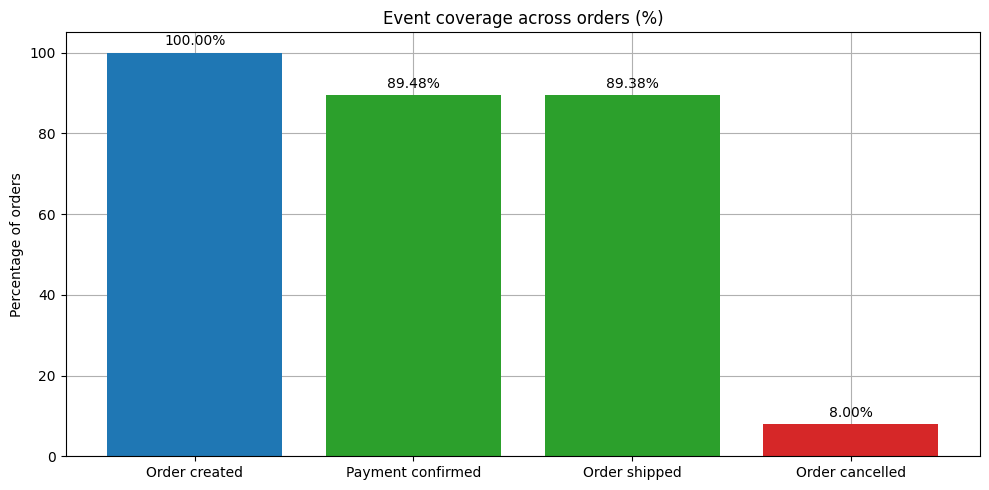

In [17]:
# 2) Event coverage across orders
# Tarkistus: kuinka suurella osuudella tilauksista kukin tapahtuma on tallennettu.
# Tarkoitus on mitata tapahtumien kattavuus order-tasolla.

sql_event_coverage = """
SELECT
  ROUND(100.0 * SUM(CASE WHEN created_event_ts IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS order_created,
  ROUND(100.0 * SUM(CASE WHEN payment_event_ts IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS payment_confirmed,
  ROUND(100.0 * SUM(CASE WHEN shipped_event_ts IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS order_shipped,
  ROUND(100.0 * SUM(CASE WHEN cancelled_event_ts IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS order_cancelled
FROM fct_orders;
"""

df_cov = run_df(sql_event_coverage)

labels = ["Order created", "Payment confirmed", "Order shipped", "Order cancelled"]
values = df_cov.iloc[0].astype(float).tolist()

colors = ["#1f77b4", "#2ca02c", "#2ca02c", "#d62728"]

plt.figure()
bars = plt.bar(labels, values, color=colors)

plt.ylim(0, 105)
plt.title("Event coverage across orders (%)")
plt.ylabel("Percentage of orders")

for bar, val in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + 1,
        f"{val:.2f}%",
        ha="center",
        va="bottom"
    )

save_fig("02_event_coverage.png")
plt.show()


### Observation

Almost all orders have an `order_created` event, which shows that the base ingestion of orders is complete.

However, around 10% of orders are missing either a `payment_confirmed` or `order_shipped` event. This means the event stream is not fully complete, even though the orders exist in the fact table.

The `order_cancelled` event appears in a small share of orders (8%), which is expected since not all orders are cancelled.

The main takeaway is that event-based metrics (for example payment rate or shipment rate) would undercount orders if missing events are not handled carefully. Event completeness should be checked before building KPIs directly from event data.


### 3. Missing events among completed orders

This chart focuses only on completed orders.  
It shows how often payment or shipment events are missing.

**Goal**

- Measure data completeness within the highest business value segment  
- Identify missing lifecycle events among completed orders  
- Evaluate potential bias in revenue and lead time calculations  
- Ensure that completed status is supported by consistent event records  


Saved figure: C:\Users\honar\projektit\Order-to-Insight\analysis\figures\03_missing_events_completed.png


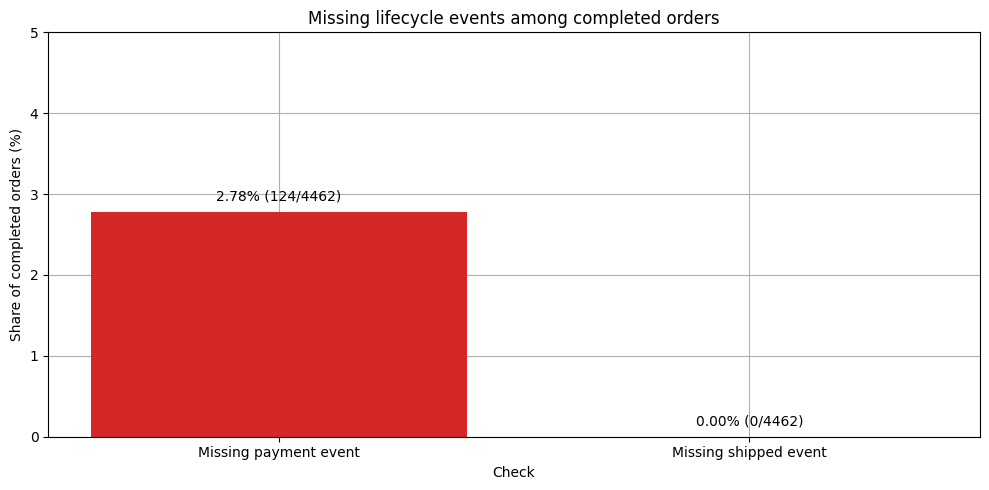

In [16]:
# 3) Completed-tilausten puuttuvat tapahtumat (payment, shipped)
# Tarkoitus mitata puuttuvien tapahtumien osuus completed-segmentissä ja tehdä riski näkyväksi.

sql_missing_completed = """
WITH completed AS (
  SELECT *
  FROM fct_orders
  WHERE order_status = 'completed'
),
agg AS (
  SELECT
    COUNT(*) AS completed_orders,
    SUM(CASE WHEN payment_event_ts IS NULL THEN 1 ELSE 0 END) AS missing_payment,
    SUM(CASE WHEN shipped_event_ts IS NULL THEN 1 ELSE 0 END) AS missing_shipped
  FROM completed
)
SELECT
  completed_orders,
  missing_payment,
  missing_shipped,
  ROUND(100.0 * missing_payment / NULLIF(completed_orders, 0), 2) AS missing_payment_pct,
  ROUND(100.0 * missing_shipped / NULLIF(completed_orders, 0), 2) AS missing_shipped_pct
FROM agg;
"""

df_miss = run_df(sql_missing_completed)

completed_orders = int(df_miss.loc[0, "completed_orders"])
missing_payment = int(df_miss.loc[0, "missing_payment"])
missing_shipped = int(df_miss.loc[0, "missing_shipped"])

pct_payment = float(df_miss.loc[0, "missing_payment_pct"])
pct_shipped = float(df_miss.loc[0, "missing_shipped_pct"])

labels = ["Missing payment event", "Missing shipped event"]
values = [pct_payment, pct_shipped]
counts = [missing_payment, missing_shipped]

plt.figure()

bars = plt.bar(
    labels,
    values,
    color=["#d62728", "#7f7f7f"]  # punainen = ongelma, harmaa = vertailu
)

y_max = max(5.0, max(values) + 1.0)
plt.ylim(0, y_max)

plt.title("Missing lifecycle events among completed orders")
plt.xlabel("Check")
plt.ylabel("Share of completed orders (%)")

for b, v, c in zip(bars, values, counts):
    plt.text(
        b.get_x() + b.get_width() / 2,
        v + (y_max * 0.02),
        f"{v:.2f}% ({c}/{completed_orders})",
        ha="center",
        va="bottom"
    )

save_fig("03_missing_events_completed.png")
plt.show()


#### Observation

Around 2.78% of completed orders are missing a payment event.  
No completed orders are missing a shipped event.

This means that even in the completed segment, some payment timestamps are not recorded.  
If revenue, funnel, or lead time metrics were calculated only from payment events, the results would slightly undercount completed orders.

Shipment data appears complete for completed orders, so shipment-based metrics are more reliable in this dataset.

# Part II – Business Impact

This section connects technical findings to revenue metrics.


### 4. Revenue definition difference

Completed revenue and paid revenue are not always equal.

Paid revenue counts only completed orders that also have a payment event.
This section shows how the choice of definition changes the reported revenue.

**Goal**
- Compare two revenue definitions side by side (status-based vs event-based)
- Quantify the revenue difference caused by missing payment events
- Make the reporting impact easy to understand without deep technical details


Saved figure: C:\Users\honar\projektit\Order-to-Insight\analysis\figures\04_revenue_definition_difference.png


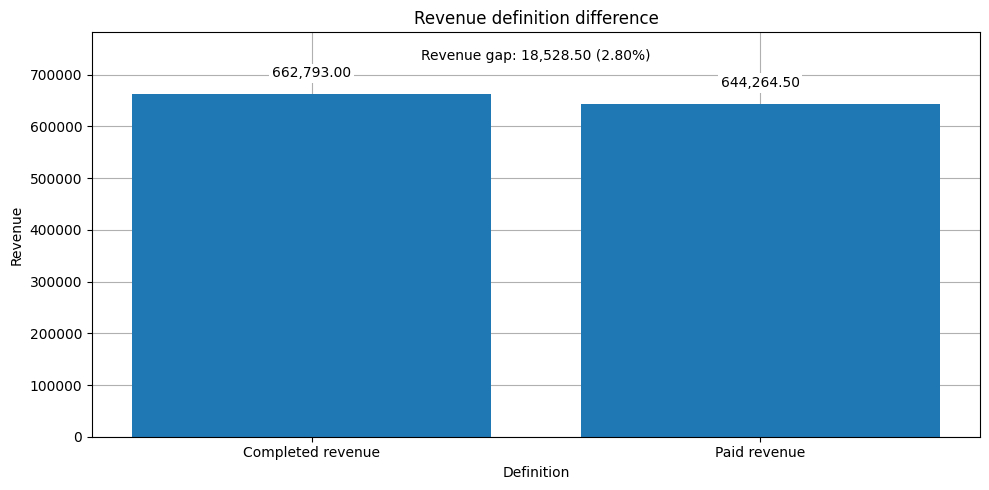

In [ ]:
# 4) Revenue definition difference
# Tarkoitus näyttää, että liikevaihto muuttuu heti jos määritelmä muuttuu.
# Verrataan kahta määritelmää:
# - completed_revenue: completed-tilausten summa
# - paid_revenue: completed-tilausten summa, mutta vain jos maksutapahtuma löytyy

sql_revenue_defs = """
SELECT
  COALESCE(SUM(CASE WHEN order_status = 'completed' THEN order_amount ELSE 0 END), 0) AS completed_revenue,
  COALESCE(SUM(CASE WHEN order_status = 'completed' AND has_payment_event = 1 THEN order_amount ELSE 0 END), 0) AS paid_revenue
FROM fct_orders;
"""

df_defs = run_df(sql_revenue_defs)

completed_revenue = float(df_defs.loc[0, "completed_revenue"])
paid_revenue = float(df_defs.loc[0, "paid_revenue"])

gap = completed_revenue - paid_revenue
gap_pct = (gap / completed_revenue * 100.0) if completed_revenue else 0.0

labels = ["Completed revenue", "Paid revenue"]
values = [completed_revenue, paid_revenue]

plt.figure()

bars = plt.bar(labels, values)

ax = plt.gca()
ax.set_title("Revenue definition difference")
ax.set_xlabel("Definition")
ax.set_ylabel("Revenue")

y_max = max(values) if values else 0
ax.set_ylim(0, y_max * 1.18 if y_max > 0 else 1)

for b, v in zip(bars, values):
    ax.text(
        b.get_x() + b.get_width() / 2,
        v + (y_max * 0.04),
        f"{v:,.2f}",
        ha="center",
        va="bottom",
        bbox=dict(facecolor="white", edgecolor="none", pad=2)
    )

ax.text(
    0.5,
    0.96,
    f"Revenue gap: {gap:,.2f} ({gap_pct:.2f}%)",
    transform=ax.transAxes,
    ha="center",
    va="top",
)

save_fig("04_revenue_definition_difference.png")
plt.show()


### Observation

Revenue can be calculated in two different ways in this project.

**Definition 1 – Status based revenue**
- Includes all orders marked as *completed*
- Does not require a recorded payment event

**Definition 2 – Event based revenue**
- Includes only completed orders
- Requires a recorded payment event

Because some completed orders are missing a payment event, the two revenue numbers are not equal.

### What this means

- Revenue depends on how it is defined
- A status-based definition gives a higher number
- An event-based definition gives a lower number

### Business impact

The key point is not only the size of the gap.

The key point is that metric definitions matter.

Data quality affects how metrics are calculated.  
Metric definitions affect reporting.  
Reporting affects business decisions.


## Conclusion

### What we validated

- Daily revenue aggregation behaves as expected  
- Event coverage is not 100% for all lifecycle steps  

The time series looked stable, but event coverage showed that some lifecycle events are missing.

---

### Two ways to calculate revenue

In this project, revenue can be calculated in two different ways:

1. **Status-based revenue**  
   All orders marked as *completed* are included.

2. **Event-based revenue**  
   Only completed orders that also have a recorded payment event are included.

Because some completed orders are missing a payment event,  
these two revenue numbers are not equal.

---

### What this means

Revenue is not just a number.  
It depends on how it is defined.

If revenue is reported based on order status, the number will be higher.  
If revenue is based only on confirmed payment events, the number will be lower.

The business impact is not only the size of the difference.  
The key point is that:

- Data quality affects metric definitions  
- Metric definitions affect business reporting  
- Business reporting affects decisions  

Before using metrics for reporting or decision making,  
event completeness must be measured and revenue logic must be clearly defined.
